In [65]:
#
#
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%matplotlib notebook


#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mpd
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#
import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep
from eq_params import *
#
from nepal_figs import *
import nepal_figs
import optimizers
#
import random
import geopy
#
#colors_ =  mpl.rcParams['axes.color_cycle']
colors_ = ['b', 'g', 'r', 'c', 'm', 'y', 'k']		# make sure these are correct...
tzutc = pytz.timezone('UTC')
#

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# TODO: wtf? check out:
#> globalETAS.elliptical_transform_test(theta = 0., x0=0., y0=0., n_quakes=100, m=6.0, max_ratio=2.0, fignum=0):
# this seems to work really well. it should be pretty much exactly the test we're writing here.

class orientation_test(object):
    
    def __init__(self, N_ev=20, theta=3.14/4., m0=7., dm=3., lat0=35., lon0=-115., dt=2.,
                     t0=dtm.datetime(2016,1,1, tzinfo=tzutc)):
        #
        # TODO:
        # something odd going on so that the transformation is not fitting correctly, but we don't see this
        # in the globalETAS.py unit test, and i don't think we see it in actualy ETAS instances... but
        # we should sort it out.
        # the globalETAS script seems to get the right pca transform; let's figure out what we're doing wrong
        # and confirm that it's not happing in real life.
        #
        L_r = 10.**(.5*m0 - 1.76)
        L = 3.5*L_r
        #print('**L,L_r = ', L, L_r)
        d_LL = L/111.1
        y_scatter = 0.
        #
        R = random.Random()
        r_factor=.2
        km2_ll = 1./111.
        m = m0-dm
        m_ms = m0
        #
        #d_lat = km2_ll*L*math.sin(theta)/N_ev
        #d_lon = km2_ll*L*math.cos(theta)/(N_ev*math.cos(lat0))
        dt = dtm.timedelta(days=dt)
        dy0=0.
        #dy0=.5*L
        LLs = [[-.5*L/111.1,dy0], [.5*L/111.1, dy0]]
        LLs = numpy.array(LLs + [[(R.random()-.5)*L_r/(111.1*math.cos(lat0)), dy0 + (R.random()-.5)*y_scatter*L_r/111.1] for j in range(N_ev)])
        #
        print('LLs: ', LLs[0:5])
        #print('theta: ', theta)
        M_r = numpy.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
        #print('M_r: ', M_r)
        LLs = numpy.dot(LLs, M_r)
        #for j,rw in enumerate(LLs):
        #    LLs[j][0]+=lon0
        #    LLs[j][1]+=lat0
        #
        # put some earthquakes on a line, then rotate them:
        #lons_lats = [[R.random()*L]]
        #plt.figure()
        #plt.plot(*zip(*LLs), marker='.', ls='')

        #
        cat = []
        #for j in range(N_ev):
        #    cat += [[t0+dt*j, lon0+j*d_lon*(1.0+R.random()*r_factor), lat0+j*d_lat*(1.0+R.random()*r_factor), m-3., mpd.date2num(t0+dt*j) ]]
        for j, (lon,lat) in enumerate(LLs):
            cat += [[t0+dt*j, lon+lon0, lat+lat0, m, mpd.date2num(t0+dt*j) ]]
        #
        tms = cat[int(.5*len(cat))][0]
        #cat += [[cat[-1][0]+dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
        #        mpd.date2num(cat[-1][0]+dt) ]]
        cat += [[tms+.5*dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
                mpd.date2num(tms+.5*dt) ]]
        #
        cat = numpy.core.records.fromarrays(zip(*cat), dtype = [('event_date', 'datetime64[us]'),
                                                                ('lon', '>f8'), ('lat', '>f8'), ('mag', '>f8'),
                                                               ('event_date_float', '>f8')])

        #cat = gep.make_ETAS_catalog_mpp(cat)
        cat = gep.make_ETAS_catalog(cat, fit_factor=2.0)
        #
        # get the pca transform (for debugging):
        xy = [cat['lon'], cat['lat']]
        cov = numpy.cov(xy)
        print('evals/vecs: ', numpy.linalg.eig(cov))
        #
        #etas = gep.ETAS_mpp(catalog=cat, lons=sorted(cat['lon'])[0::len(cat)-1],  lats=sorted(cat['lat'])[0::len(cat)-1]),
        etas = gep.ETAS_mpp(catalog=cat )
        #
        plt.figure(figsize=(8,6))
        plt.clf()
        plt.plot(cat['lon'], cat['lat'], marker='o', ls='')
        plt.plot(cat['lon'][-1], cat['lat'][-1], marker='*', color='r', ls='', ms=16)
        #plt.plot(cat2['lon'], cat2['lat']+.25, marker='o', ls='', color='r')'
        for x,y in itertools.product(sorted(cat['lon'])[0::len(cat)-1], sorted(cat['lat'])[0::len(cat)-1]):
            plt.plot([x],[y], '.')
        #
        #return etas
        self.__dict__.update(locals())

   

LLs:  [[-0.86561344  0.        ]
 [ 0.86561344  0.        ]
 [-0.27009646  0.        ]
 [ 0.13233131  0.        ]
 [-0.15144017  0.        ]]
evals/vecs:  (array([  3.84639784e-02,   6.93889390e-18]), array([[ 0.70738827, -0.70682518],
       [ 0.70682518,  0.70738827]]))
begin globalETAS.__init()__
Overriding t0 (etas catalog start date/time) for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-12-11 00:07:33.657387+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 103], None)
make_etas():
etas_mpp worker xyz_range:  [0, 169]
begin globalETAS.__init()__
Overriding t0 (etas catalog start date/time) for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-12-11 00:07:33.657387+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 103], [0, 169])
now gather sub-arrays...
begin make_etas_rtree()
len(local_lattice_dict):  169
Indices initiated. begin ETAS ::  [0, 103]


/home/myoder/Documents/Research/yoder/globalETAS/globalETAS.py:1119: RuntimeWarning: invalid value encountered in double_scalars
  R_prime = R * numpy.linalg.norm([dx_prime,dy_prime])/numpy.linalg.norm([dx,dy])


finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 103])
ETAS complete.
(datetime.datetime(2016, 4, 13, 0, 0), -115.01337998545218, 34.98663066514865, 7.0, 736067.0, 54.954087385762456, 997.8404925454946, 2.0021630113650087e-05, 16.595869074375614, 126.65018464658773, 0.0019486750167964611, 1.0, 1.1, 1.5, array([  1.23707705e+08,   6.28336261e+02]), array([[ 0.93724017,  0.34868449],
       [-0.34868449,  0.93724017]]), 103.0)
finished...


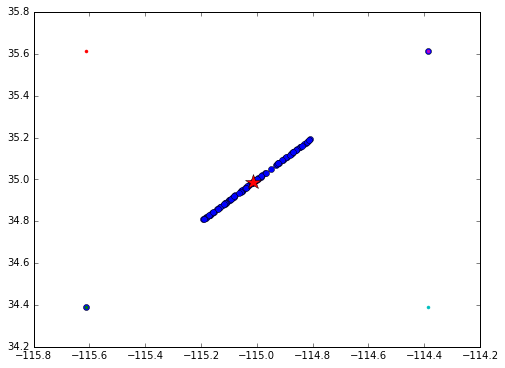

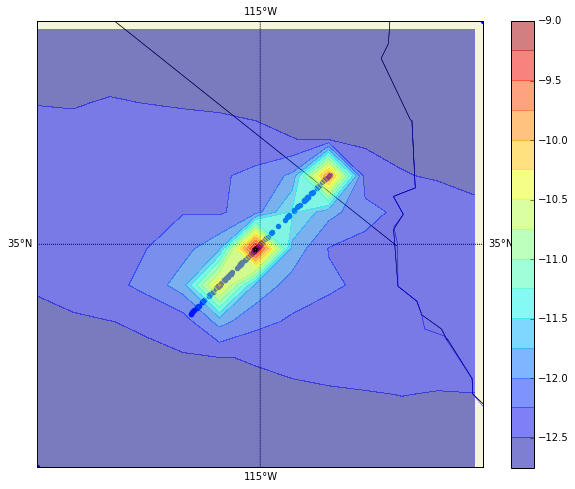

In [67]:
#etas = orientation_test(N_ev=50, theta=0.*3.14/4.)
#for theta in [3.14/6, 3.14/4., 3.14/2., .75*3.14]:
for theta in [-3.14/4.]:
    etas = None
    etas = orientation_test(N_ev=100, theta=theta, m0=7., dm=4.)
    #
    plt.figure(figsize=(10,8))
    plt.clf()
    ax=plt.gca()
    etas.etas.make_etas_contour_map(ax=ax)
    ms=etas.etas.catalog[0]
    for ev in etas.etas.catalog:
        #x,y = etas.etas.cm(ev['lon'], ev['lat'])
        if ev['mag']>ms['mag']: ms=ev
        x,y = ev['lon'], ev['lat']
        etas.etas.cm.scatter(x,y, marker='o', edgecolors='b')
    print(etas.etas.catalog[-1])
    etas.etas.cm.scatter(ms['lon'], ms['lat'], marker='*', s=28, c='m', zorder=11)
print('finished...')

In [68]:
XY = numpy.array(list(zip(etas.cat['lon'], etas.cat['lat'])))

cov:  [[ 0.0192473   0.01923198]
 [ 0.01923198  0.01921667]]
eig_vals:  [  3.84639784e-02  -1.38777878e-17]
eig_vecs:  [[ 0.70738827 -0.70682518]
 [ 0.70682518  0.70738827]]


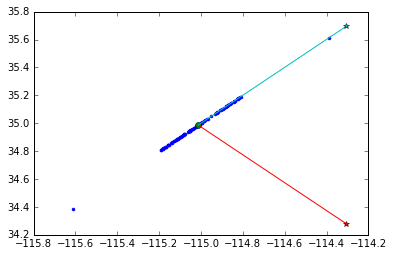

In [69]:
plt.figure()
plt.plot(*zip(*XY), marker='.', ls='')

cov = numpy.cov(XY.T)
print('cov: ', cov)
eig_vals, eig_vecs = numpy.linalg.eig(cov)
print('eig_vals: ', eig_vals)
print('eig_vecs: ', eig_vecs)
#
x0 = numpy.mean([x for x,y in XY])
y0 = numpy.mean([y for x,y in XY])
plt.plot([x0], [y0], 'o')
# for ev in eig_vecs:
#     print('ev: ', ev)
#     #plt.plot(*zip([x0,y0], ev+numpy.array([x0,y0])), marker='.', ls='-')
#     plt.plot([x0, x0+ev[0]], [y0, y0+ev[1]], marker='.', ls='-')
evs = eig_vecs
plt.plot([x0, x0+evs[0][0]], [y0, y0+evs[0][1]], ls='-', color='r')
plt.plot([x0, x0+evs[1][0]], [y0, y0+evs[1][1]], ls='-', color='c')

plt.plot([x0+evs[0][0]], [y0+evs[0][1]], '*')
plt.plot([x0+evs[1][0]], [y0+evs[1][1]], '*')


In [70]:
print(numpy.dot(evs[0], evs[1]))

0.0


In [71]:
print(etas.LLs[0:10])

[[-0.61232479 -0.61183737]
 [ 0.61232479  0.61183737]
 [-0.19106307 -0.19091098]
 [ 0.09360962  0.0935351 ]
 [-0.107127   -0.10704172]
 [-0.01831843 -0.01830385]
 [-0.13050321 -0.13039933]
 [-0.11536526 -0.11527343]
 [-0.05337112 -0.05332864]
 [-0.08048606 -0.080422  ]]


In [72]:
eq=gep.Earthquake(etas.etas.catalog[-1])

In [73]:
print(eq.e_vals, eq.e_vals_n, eq.e_vecs)

[  1.23707705e+08   6.28336261e+02] [5.0, 0.2] [[ 0.93724017  0.34868449]
 [-0.34868449  0.93724017]]


In [74]:
eq1=gep.Earthquake(etas.etas.catalog[1])

In [75]:
print(eq1.e_vals, eq1.e_vals_n, eq1.e_vecs)

[ 1.  1.] [1.0, 1.0] [[ 1.  0.]
 [ 0.  1.]]
